Projeto PAIM Calcular Dimensão Fractal

Guilherme Gâmbaro e Julia Cristina da Silva Oliveira


---

# Dimensão de regularidade da substância cinzenta

Bibliotecas

In [ ]:
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

Carregar imagem

In [ ]:
# Carregando Figura
img = nib.load('wc1c115724_xtra_T1w_MPR1_reorient_sformMod.nii')
img_data = img.get_fdata()
img_data = img_data[:,:,90] # Selecionando fatia 90

Converter imagem para 8 bits

In [ ]:
# Normalizar a imagem para o intervalo 0-255
img_normalized = 255 * (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

# Converter para 8 bits inteiros
img_uint8 = img_normalized.astype(np.uint8)

Criar imagem binária

In [ ]:
# Binarizar a imagem
_, binary_matrix = cv2.threshold(img_uint8, 127, 255, cv2.THRESH_BINARY)

Contornar maior borda

In [ ]:
# Encontrar os contornos
contours, _ = cv2.findContours(binary_matrix, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Selecionar o contorno da maior figura
largest_contour = max(contours, key=cv2.contourArea)

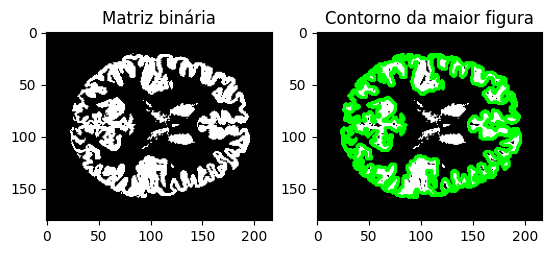

In [ ]:
# Plot
# Exibir a imagem original e a imagem com contornos

# Desenhar o contorno da maior figura
image_bordas = cv2.cvtColor(binary_matrix, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_bordas, [largest_contour], -1, (0, 255, 0), 2)  # Desenhar o contorno em verde

plt.subplot(1, 2, 1)
plt.title('Matriz binária')
plt.imshow(binary_matrix, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Contorno da maior figura')
plt.imshow(image_bordas)

plt.show()

Calcular distância do centro até a borda (Criando série)

In [ ]:
# Calcular o centro da imagem (assumindo que a imagem é quadrada ou retangular)
image_center = (img_uint8.shape[1] // 2, img_uint8.shape[0] // 2)

# Função para calcular a distância euclidiana
def distance(point, center):
    return np.sqrt((point[0] - center[0]) ** 2 + (point[1] - center[1]) ** 2)

# Calcular as distâncias da borda até o centro
distances = []
angles = []

for point in largest_contour:
    point = point[0]  # Desempacotar o ponto
    dist = distance(point, image_center)
    distances.append(dist)

    # Calcular o ângulo polar e converter para graus
    angle = np.arctan2(point[1] - image_center[1], point[0] - image_center[0])
    angle_deg = np.degrees(angle)  # Converter para graus
    angles.append(angle_deg)

# Ordenar os pontos pelo ângulo para garantir o sentido horário
angles, distances = zip(*sorted(zip(angles, distances)))

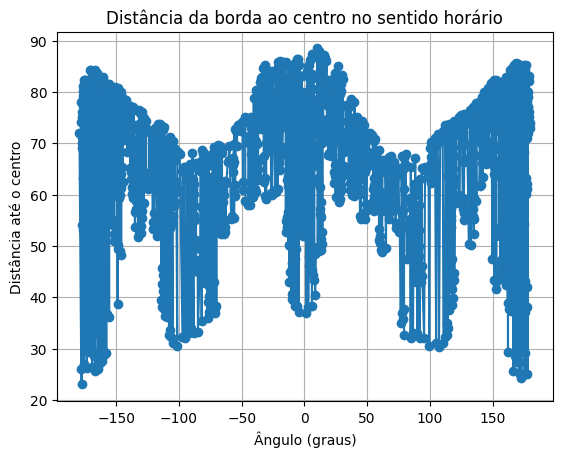

In [ ]:
# Plot

# Ordenar os pontos pelo ângulo para garantir o sentido horário
angles, distances = zip(*sorted(zip(angles, distances)))

# Plotar as distâncias em função do ângulo (em graus) no sentido horário
plt.figure()
plt.plot(angles, distances, 'o-')
plt.title("Distância da borda ao centro no sentido horário")
plt.xlabel("Ângulo (graus)")
plt.ylabel("Distância até o centro")
plt.grid(True)
plt.show()

Calcular entropia da série

In [ ]:
def sample_entropy(time_series, m, r):
    """
    Calculate the Sample Entropy of a time series.

    Parameters:
    time_series : array-like
        The input time series data.
    m : int
        The length of sequences to be compared (embedding dimension).
    r : float
        Tolerance for accepting matches (typically set to 0.1 * standard deviation of the time series).

    Returns:
    float
        The Sample Entropy of the time series.
    """
    n = len(time_series)
    if n <= m:
        return np.nan  # Not enough data

    # Create the template vectors
    def _template_vectors(time_series, m):
        """Generate template vectors of length m."""
        return [time_series[i:i + m] for i in range(n - m + 1)]

    # Get template vectors for m and m + 1
    templates_m = _template_vectors(time_series, m)
    templates_m1 = _template_vectors(time_series, m + 1)

    # Count matches for templates of length m
    def _count_matches(templates, r):
        count = 0
        for i in range(len(templates)):
            for j in range(len(templates)):
                if i != j and np.max(np.abs(templates[i] - templates[j])) <= r:
                    count += 1
        return count

    matches_m = _count_matches(templates_m, r)
    matches_m1 = _count_matches(templates_m1, r)

    # Calculate Sample Entropy
    if matches_m == 0 or matches_m1 == 0:
        return np.nan  # Avoid division by zero
    samp_en = -np.log(matches_m1 / matches_m)

    return samp_en

In [ ]:
entropia = []
eixo_x = []
r = 0.1
time_series = np.array(distances)
for i in range(1,10):
    m = i
    samp_en = sample_entropy(time_series, m, r)
    entropia.append(samp_en)
    eixo_x.append(np.log(1/m))
    print(samp_en)

4.573237138885082
3.1986731175506815
nan
nan
nan
nan
nan
nan
nan


In [ ]:
indices_nan_entropia = np.isnan(entropia) # Como a entropia nem sempre vai ser definida, vou inditificar quando ela não eh definida
entropia = np.delete(entropia, indices_nan_entropia) # Deletando nan
eixo_x = np.delete(eixo_x, indices_nan_entropia) # Deletando nan
coeficiente = np.polyfit(eixo_x, entropia, 1)
coeficiente_angular = coeficiente[0]
dimensao_regularidade = coeficiente_angular
print('dimensao de regularidade = ', dimensao_regularidade)

dimensao de regularidade =  1.9830766969635314


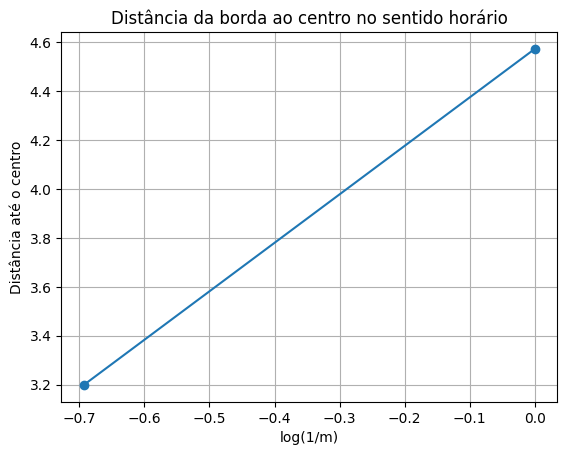

In [ ]:
# Plot
plt.figure()
plt.plot(eixo_x, entropia, 'o-')
plt.title("Distância da borda ao centro no sentido horário")
plt.xlabel("log(1/m)")
plt.ylabel("Distância até o centro")
plt.grid(True)
plt.show()

In [ ]:
eixo_x = [np.log(1/1), np.log(1/2)]
entropia = [4.110517421467701, 3.6463198396951406]
entropia = entropia[:2]
coeficiente = np.polyfit(eixo_x, entropia, 1)
coeficiente_angular = coeficiente[0]
print(coeficiente_angular)

0.6696955492159234


---

In [ ]:
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt

def sample_entropy(time_series, m, r):
    n = len(time_series)
    if n <= m:
        return np.nan  # Not enough data

    # Create the template vectors
    def _template_vectors(time_series, m):
        """Generate template vectors of length m."""
        return [time_series[i:i + m] for i in range(n - m + 1)]

    # Get template vectors for m and m + 1
    templates_m = _template_vectors(time_series, m)
    templates_m1 = _template_vectors(time_series, m + 1)

    # Count matches for templates of length m
    def _count_matches(templates, r):
        count = 0
        for i in range(len(templates)):
            for j in range(len(templates)):
                if i != j and np.max(np.abs(templates[i] - templates[j])) <= r:
                    count += 1
        return count

    matches_m = _count_matches(templates_m, r)
    matches_m1 = _count_matches(templates_m1, r)

    # Calculate Sample Entropy
    if matches_m == 0 or matches_m1 == 0:
        return np.nan  # Avoid division by zero
    samp_en = -np.log(matches_m1 / matches_m)

    return samp_en

def dr(caminho_imagem, fatia, r):
    # Carregar imagem
    img = nib.load(caminho_imagem)
    img_data = img.get_fdata()
    img_data = img_data[:,:, fatia]

    # Crir imagem binária
    img_normalized = 255 * (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data)) # Normalizar a imagem para o intervalo 0-255
    img_uint8 = img_normalized.astype(np.uint8) # Converter para 8 bits inteiros
    _, binary_matrix = cv2.threshold(img_uint8, 127, 255, cv2.THRESH_BINARY) # Binarizar a imagem

    # Contorno externo da figura
    contours, _ = cv2.findContours(binary_matrix, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Encontrar os contornos
    largest_contour = max(contours, key=cv2.contourArea) # Selecionar o contorno da maior figura

    # Calculando distância do centro até a borda (Criando série)
    image_center = (img_uint8.shape[1] // 2, img_uint8.shape[0] // 2)
    def distance(point, center): # Função para calcular a distância euclidiana
        return np.sqrt((point[0] - center[0]) ** 2 + (point[1] - center[1]) ** 2)
    distances = []
    angles = []
    for point in largest_contour: # Calcular as distâncias da borda até o centro
        point = point[0]  # Desempacotar o ponto
        dist = distance(point, image_center)
        distances.append(dist)
        angle = np.arctan2(point[1] - image_center[1], point[0] - image_center[0]) # Calcular o ângulo polar e converter para graus
        angle_deg = np.degrees(angle)  # Converter para graus
        angles.append(angle_deg)
    angles, distances = zip(*sorted(zip(angles, distances))) # Ordenar os pontos pelo ângulo para garantir o sentido horário

    # Calcular entropia da série
    entropia = []
    eixo_x = []
    time_series = np.array(distances)
    # r = r * np.std(time_series) # r é multiplicado pelo desvio padrao da serie
    for m in range(1,6):
        samp_en = sample_entropy(time_series, m, r)
        entropia.append(samp_en)
        eixo_x.append(np.log(1/m))

    # Calculando dimensão de regularidade
    indices_nan_entropia = np.isnan(entropia) # Como a entropia nem sempre vai ser definida, vou inditificar quando ela não eh definida
    entropia = np.delete(entropia, indices_nan_entropia) # Deletando nan
    eixo_x = np.delete(eixo_x, indices_nan_entropia) # Deletando nan
    coeficiente = np.polyfit(eixo_x, entropia, 1)
    coeficiente_angular = coeficiente[0]
    dimensao_regularidade = coeficiente_angular
##############################
    # Plotando gráficos
    # Exibir a imagem original e a imagem com contornos

    # Desenhar o contorno da maior figura
    image_bordas = cv2.cvtColor(binary_matrix, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(image_bordas, [largest_contour], -1, (0, 255, 0), 2)  # Desenhar o contorno em verde
    plt.subplot(1, 2, 1)
    plt.title('Matriz binária')
    plt.imshow(binary_matrix, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Contorno da maior figura')
    plt.imshow(image_bordas)
    plt.show()

    plt.figure()
    plt.plot(angles, distances)
    plt.title("Distância da borda ao centro no sentido horário")
    plt.xlabel("Ângulo (graus)")
    plt.ylabel("Distância até o centro")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(eixo_x, entropia, 'o-') #'o-'
    plt.title("Distância da borda ao centro no sentido horário")
    plt.xlabel("log(1/m)")
    plt.ylabel("Distância até o centro")
    plt.grid(True)
    plt.show()

    return dimensao_regularidade

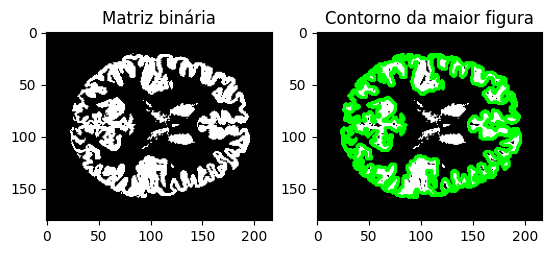

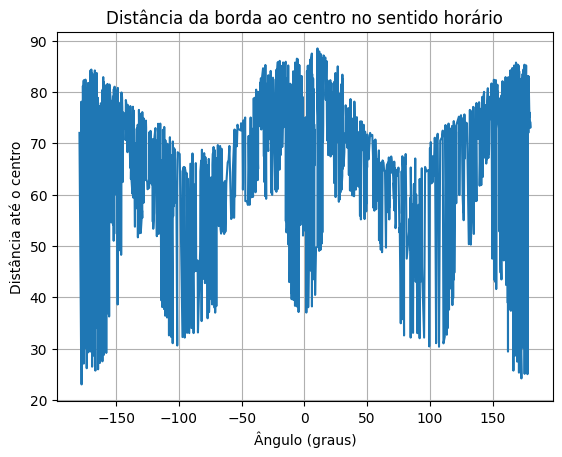

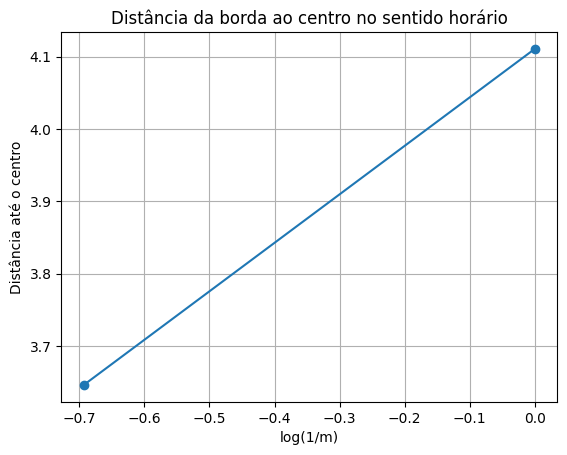

0.6696955492159234


In [ ]:
dm = dr('wc1c115724_xtra_T1w_MPR1_reorient_sformMod.nii', 90, 0.3)
print(dm)

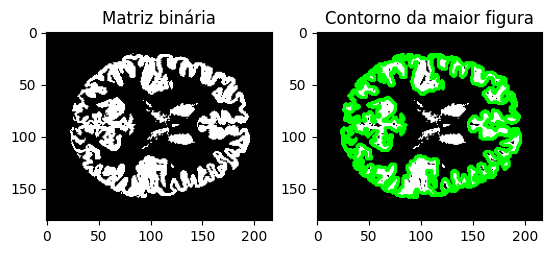

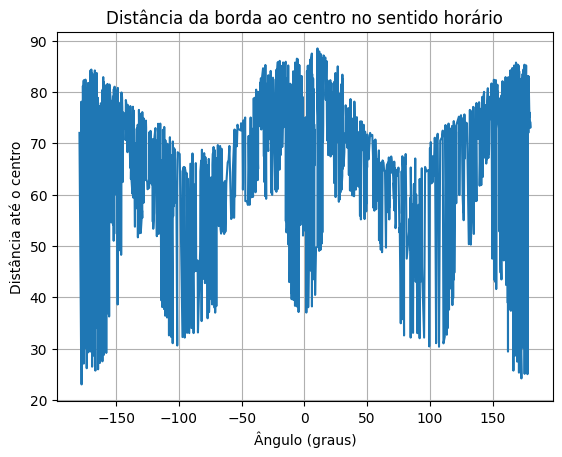

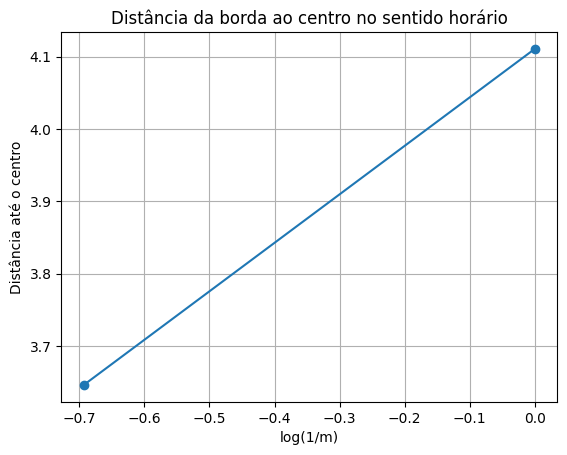

0.6696955492159234


In [ ]:
dm = dr('wc1c115724_xtra_T1w_MPR1_reorient_sformMod.nii', 90, 0.3)
print(dm)

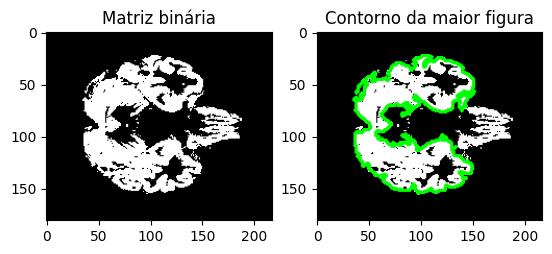

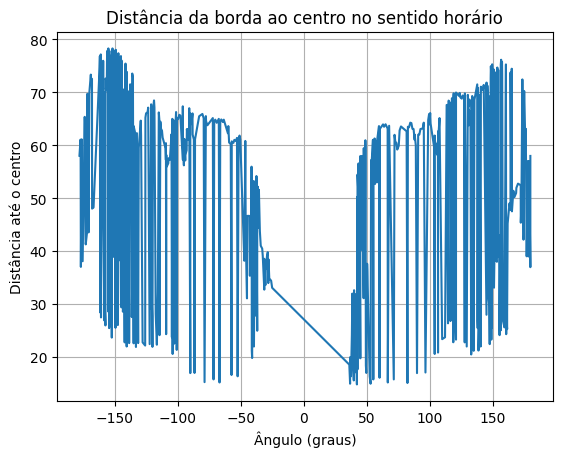

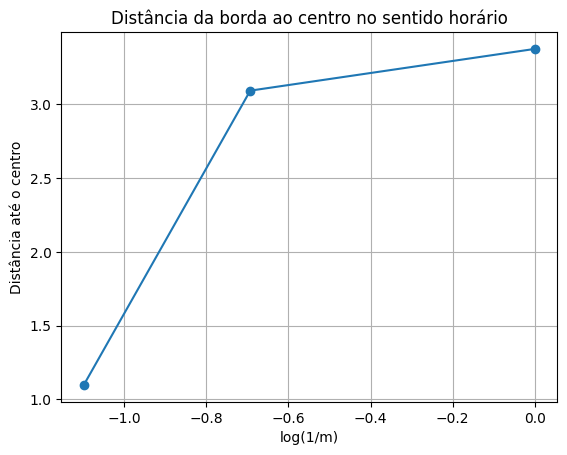

1.8916405013703697


In [ ]:
dm = dr('wc1c115724_xtra_T1w_MPR1_reorient_sformMod.nii', 45, 0.3)
print(dm)

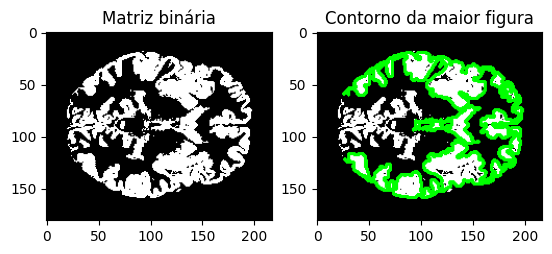

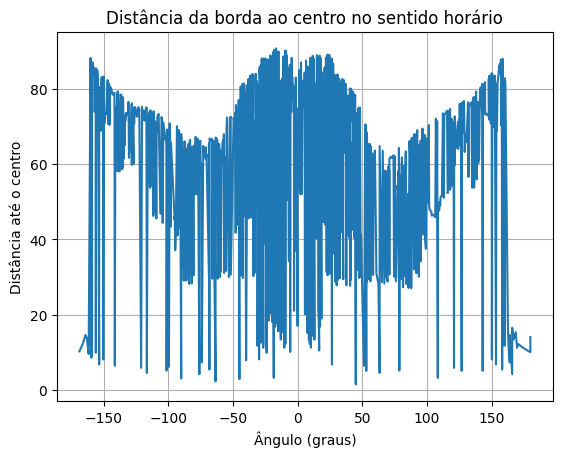

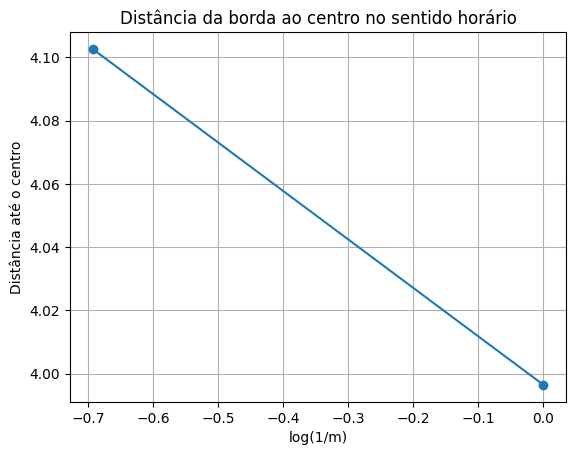

-0.15319699213070212


In [ ]:
dm = dr('wc1c115724_xtra_T1w_MPR1_reorient_sformMod.nii', 70, 0.3)
print(dm)

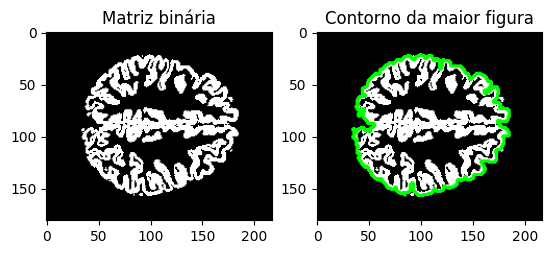

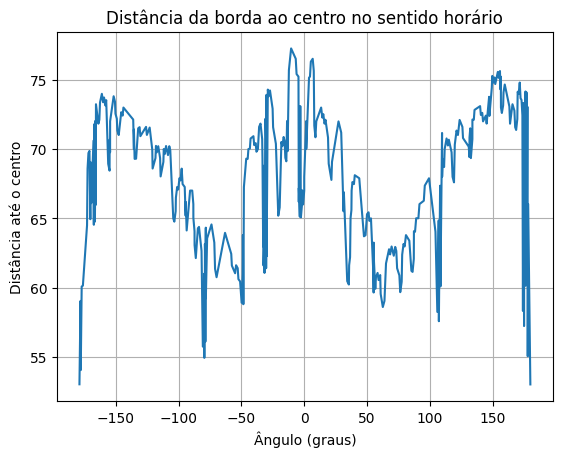

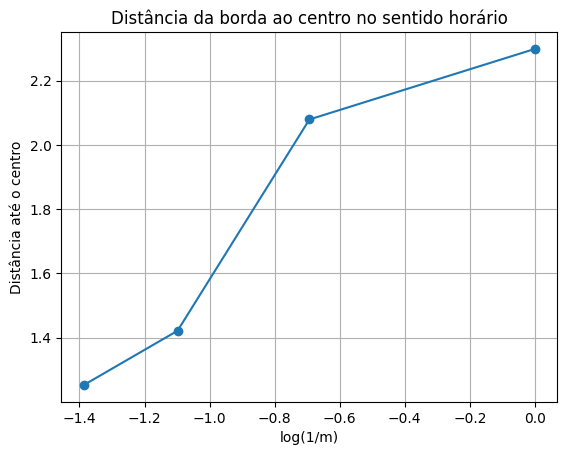

0.7967780473644875


In [ ]:
dm = dr('wc1c115724_xtra_T1w_MPR1_reorient_sformMod.nii', 110, 0.3)
print(dm)

---

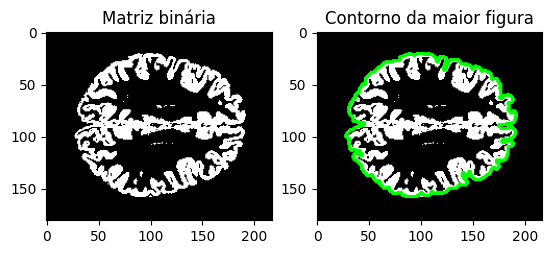

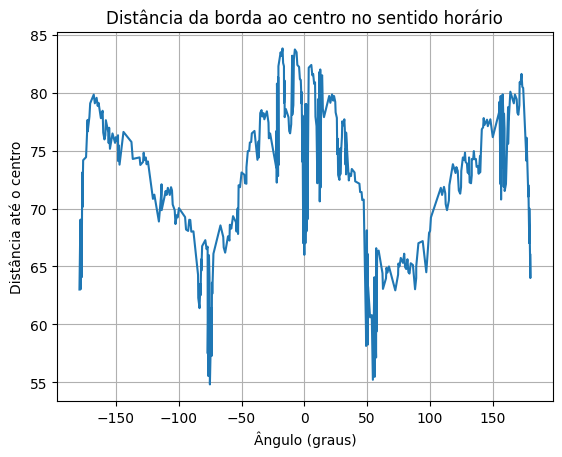

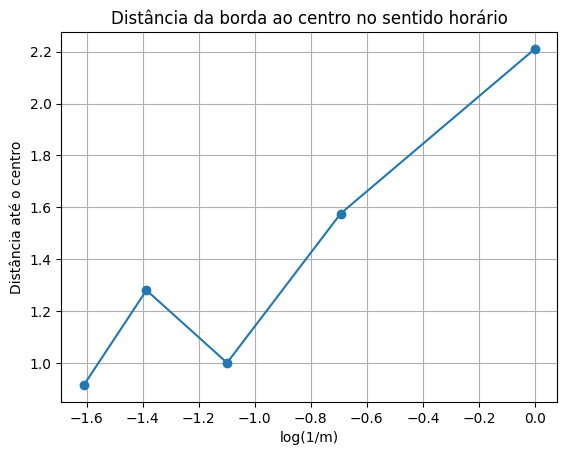

0.7707036383127704


In [ ]:
dm = dr('wc1c115724_xtra_T1w_MPR1_reorient_sformMod.nii', 100, 0.3)
print(dm)

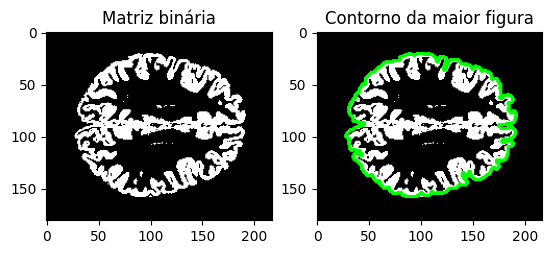

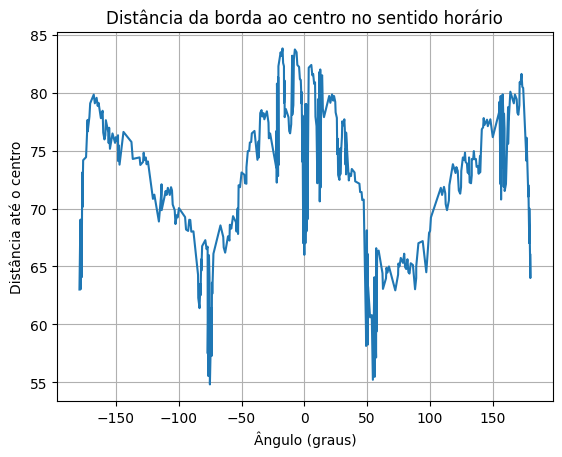

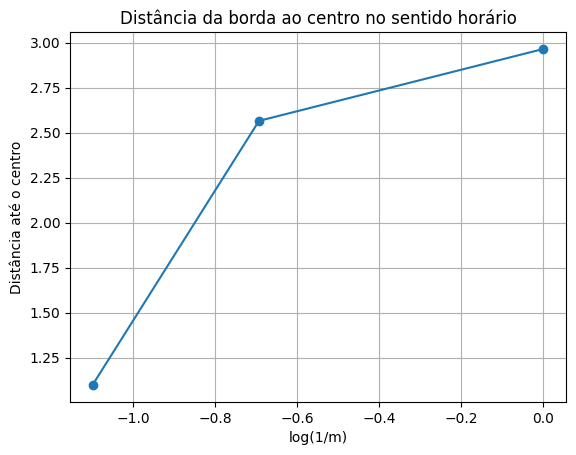

1.57756808072417


In [ ]:
dm = dr('wc1c115724_xtra_T1w_MPR1_reorient_sformMod.nii', 100, 0.1)
print(dm)